In [147]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io, os, re, math
from scipy.io import matlab
from datetime import datetime
from Mouse_Data import Mouse_Data
from helpers import *
from visualization import *
pd.options.mode.chained_assignment = None  # default='warn'
matplotlib.rcParams.update({'font.size':18, 'font.family':'Times New Roman', 
                            'axes.facecolor':'white' , 'figure.facecolor':'white', 'figure.dpi':100})   

root = 'D:/mStim_data/PSI/'
path_ext = '/microstim/Session Data/'

ctrl_IDs = ['SNA-123599', 'SNA-126687', 'SNA-126688', 'SNA-127100']
exp_IDs = ['SNA-123995','SNA-123996', 'SNA-127101', 'SNA-127102'] # In this case it refers to 200 nL superficial rapamycin injection

ctrl_data = []
for ID in ctrl_IDs:
    mouse = Mouse_Data(root+ID+path_ext)
    ctrl_data.append(mouse)

# DLC analysis
Needs to provide a dataframe for each trial (with checked framesize) with the columns: whisker position raw, z-scored, likelihood, checks, timestamps
1. Unpack the .h5 file
2. Check the frameCount according to the feature
3. Define a heuristic for checking whisker movement
4. z-score the whisker position
5. Provide timestamps of response time and success
6. Visualize the data

In [122]:
# Add DLC data to the Mouse_Data Class
mouse = ctrl_data[1]
print(mouse.id)
mouse.get_dlc('whisker')
# display(mouse.session_data['22_11_2023'][20:60])

SNA-126687
SNA-126687 15_10_2023 doesnt seem to have any folder with recordings for the whisker feature.
16_10_2023 doesnt have any DLC-files.
18_10_2023 doesnt have any DLC-files.


In [123]:
def preAnalyze_whisking(mouse_data, check_LL=False, ll_threshold=0.99):
    ''' Takes raw whisking data and converts it into a readable dictionary

        INPUT:
            mouse_data(Class):
            check_LL(bool): do you want to remove the trials with low average likelihood tracking
            ll_threshold(float): how high should the average likelihood be?

        OUTPUT:
            mouse_data(Class) updated Mouse_Data with pre analyzed whiskers
    ''' 
    prepMouse = deepcopy(mouse_data)
    # Create a whisking_dictionary for all session
    for session in prepMouse.sessions:
        session_data = prepMouse.session_data[session]
       
        # Organize all y-position and likelihood data
        for trial in session_data.iterrows(): ## TODO check if NAN
            nTrial, trial = trial
            
            # Skip trials that do not have DLC data
            if isinstance(trial['whisker'], dict):
                print(f'The whisking data apprears to already have been preanalyzed')
                continue
            elif not isinstance(trial['whisker'], (pd.DataFrame, pd.core.series.Series)):
                print(f'No DLC DataFrame found for Trial: {nTrial} of {prepMouse.id}, session {session}')
                continue

            # Save it in a dictionary
            # The raw whisker data needs to be unpacked into left and right whisker
            whisking_dict = {'left_whisker': {'y':None, 'likelihood':None}, 
                             'right_whisker':{'y':None, 'likelihood':None}, 
                             'nose':{'y':None, 'likelihood':None}}

            # Go through all important feature points
            for featurePoint, feature in zip(['left_tip', 'right_tip', 'nose'], ['left_whisker', 'right_whisker', 'nose']):

                # Check the average likelihood of tracking during this trial
                if check_LL:
                    likelihood = trial['whisker'][featurePoint]['likelihood']
                    
                    if np.mean(likelihood) >= ll_threshold:
                        whisking_dict[feature]['y'] = trial['whisker'][featurePoint]['y']
                        whisking_dict[feature]['likelihood'] = trial['whisker'][featurePoint]['likelihood']

                    # TODO: Interpolate between correctly estimated whisker postions and remove low ll
                        
                else: 
                    # print(trial['whisker']) # This yields NaN
                    whisking_dict[feature]['y'] = trial['whisker'][featurePoint]['y']
                    whisking_dict[feature]['likelihood'] = trial['whisker'][featurePoint]['likelihood']

                # Change to dataframe    
                whisking_dict[feature] = pd.DataFrame.from_dict(whisking_dict[feature])
                
            # Now update the whisking data to a more readable one
            prepMouse.session_data[session]['whisker'].iloc[nTrial] = whisking_dict
        # Reformat Mouse_Data.full_data
        prepMouse.compile_data()
    return prepMouse

prepMouse = preAnalyze_whisking(mouse)

No DLC DataFrame found for Trial: 0 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 1 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 2 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 3 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 4 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 5 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 6 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 7 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 8 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 9 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 10 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 11 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 12 of SNA-126687, session 15_10_2023
No DLC DataFrame found for Trial: 13 of SNA-126687, session 15_10_2023
No DLC DataFrame

## Whisker normalization
This aims to normalize the whisker position for every session. It is supposed to be normalized to the nose position.
We need to go through the following steps:

1. Calculate the difference between the nose and the whisker tip (delta_y)
2. For every session get the max and min delta_y
3. min_max normalize for the session

### GPT advice 
1. Loop through each video of the session and get the DLC data
    * Check the DLC video for frame count and tracking accuracy
    * What if the some tracking points are dropped: interpolate?
2. Calculate deltaY (distance from whiskertip to nose)
3. Find the min and max position over the session 
    * Individual trials wouldn't work because some have an absence of whisking
4. Normalize the scores min and max position

In [214]:
def calc_deltaY(whisker_coordinates): #TODO why only a unilateral whisker?
    ''' Takes the whisker_dictionary from a single trial and calculates the distance
        between the y-postion of the nose and that of the whisker tip. A high deltaY represents whisker protraction.
    '''
    nose = whisker_coordinates['nose']['y']
    whisker = whisker_coordinates['right_whisker']['y']
    deltaY = whisker - nose
    if any(deltaY <= -50): # TODO this should be fleshed out more for it has some merit.
        # print('Wrong whisker')
        pass
    return deltaY

def normalizeWhisker(session_data, n_avg=25): # TODO delta y needs to be of multiple sessions
    # TODO what if already analyzed it creates very SLOW code
    # TODO what if the whisker was improperly painted?
    ''' Min-max normalizes the whisker postion. 
    '''
    normalized_coords = []
    session_dy = pd.Series([], dtype=int)

    # Go through all trial of the session
    for ntrial, trial in session_data.iterrows():
        if isinstance(trial['whisker'], float):
            if math.isnan(trial['whisker']):# TODO if this is full of NaN it is still a Series full of NaN if it isnt nan the code doesnt work
                continue
  
        # Calculate deltaY
        deltaY = calc_deltaY(trial['whisker'])
        session_dy = pd.concat([session_dy, deltaY])

    # Unless it was empty
    if len(session_dy) == 0:
        return False
    
    # Now that we have a list of all deltaY whisker position
    # Get the coordinates of the n highest and n lowest
    else:
        whisker_min = np.mean(session_dy.nsmallest(n_avg)) # retracted_coords
        whisker_max = np.mean(session_dy.nlargest(n_avg)) # protracted_coords
        
        # Now we go back through each trial
        for ntrial, trial in session_data.iterrows():
            if isinstance(trial['whisker'], float):
                if math.isnan(trial['whisker']):
                    continue

            # Perform min-max normalization
            deltaY= calc_deltaY(trial['whisker'])
            normalized_coord = (deltaY - whisker_min) / (whisker_max - whisker_min)

            # Change the session_data from raw pixel coordinates to normalized score TODO maybe update the Mouse_Data
            normalized_coords.append(normalized_coord)

            # TODO like preAnalyze whisking, I would like to update the Mouse_Data, this way we can min max over the whole session in stead of doing that after. (see below)

    return normalized_coords

mouse = ctrl_data[3]
print(mouse.id)
mouse.get_dlc('whisker')
prepMouse = preAnalyze_whisking(mouse)
normMouse = deepcopy(prepMouse)

SNA-127100
No DLC DataFrame found for Trial: 45 of SNA-127100, session 22_11_2023
No DLC DataFrame found for Trial: 46 of SNA-127100, session 22_11_2023
No DLC DataFrame found for Trial: 47 of SNA-127100, session 22_11_2023
No DLC DataFrame found for Trial: 48 of SNA-127100, session 22_11_2023
No DLC DataFrame found for Trial: 0 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 1 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 2 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 3 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 4 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 5 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 6 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 7 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 8 of SNA-127100, session 23_11_2023
No DLC DataFrame found for Trial: 9 of SNA-127100, session 23_11_2023
No DL

In [216]:
succes = pd.DataFrame([])
miss = pd.DataFrame([])
corr_rej = pd.DataFrame([])
false = pd.DataFrame([])
for i in range(4):
    # i = 3
    # Hit
    session_data = normMouse.session_data[normMouse.sessions[i]]
    session_data = select_trialType(session_data, 1)
    session_data = session_data.loc[session_data['success'] == True]

    x = normalizeWhisker(session_data)
    if x:
        succes = pd.concat([succes, pd.DataFrame(x)])

    # Miss
    session_data = normMouse.session_data[normMouse.sessions[i]]
    session_data = select_trialType(session_data, 1)
    session_data = session_data.loc[session_data['success'] == False]

    x = normalizeWhisker(session_data)
    if x:
        miss = pd.concat([miss, pd.DataFrame(x)])
        # Simple yet important node

    # Correct rejection
    session_data = normMouse.session_data[normMouse.sessions[i]]
    session_data = select_trialType(session_data, 2)
    session_data = session_data.loc[session_data['success'] == False]

    x = normalizeWhisker(session_data)
    if x:
        corr_rej = pd.concat([corr_rej, pd.DataFrame(x)])

        
    # fp
    session_data = normMouse.session_data[normMouse.sessions[i]]
    session_data = select_trialType(session_data, 2)
    session_data = session_data.loc[session_data['success'] == True]

    x = normalizeWhisker(session_data)
    if x:
        false = pd.concat([false, pd.DataFrame(x)])

    

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

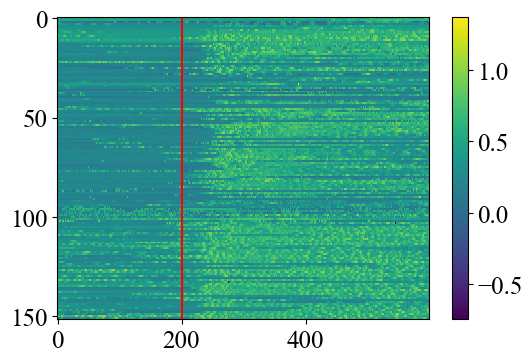

FP


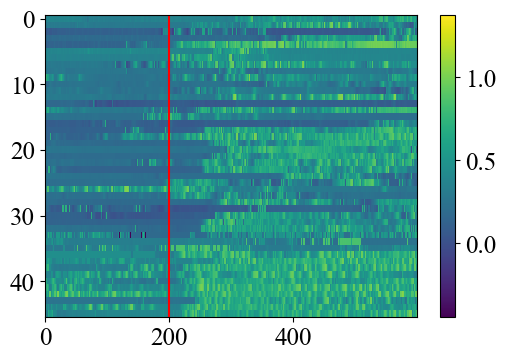

MISS


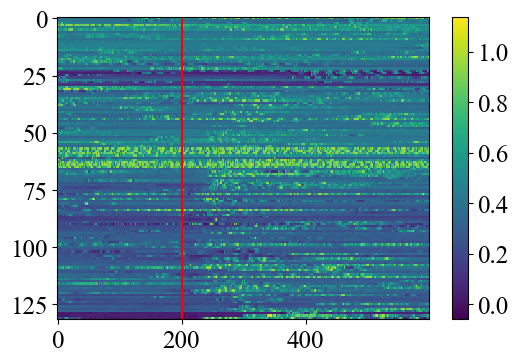

Corr Rej


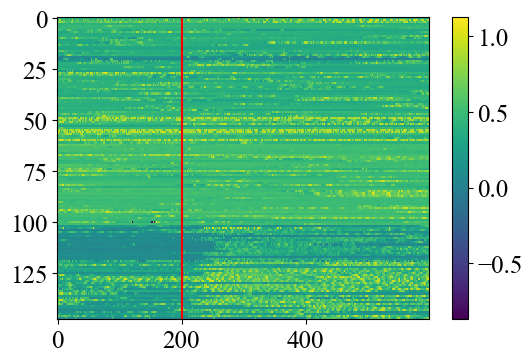

In [213]:
plt.imshow(succes, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.axvline(200, c='red')
plt.show()

print('FP')
plt.imshow(false, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.axvline(200, c='red')
plt.show()

print('MISS')
plt.imshow(miss, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.axvline(200, c='red')
plt.show()


print('Corr Rej')
plt.imshow(corr_rej, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.axvline(200, c='red')
plt.show()


# Correlate whisking behaviour to outcome
We will need to grab the 200 frames before stimulus onset and apply a label (outcome) to it
Then we correlate, but idk yet how